In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import json
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import scipy.sparse as sp
import random
import time
from tqdm import tqdm
import random

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/kienanana/Documents/SCHOOL/Y3S1/BT4222/PROJECT/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/kienanana/Documents/SCHOOL/Y3S1/BT4222/PROJECT/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/kienanana/Documents/SCHOOL/Y3S1/BT4222/PROJECT/.venv/lib/py

In [4]:
def read_json_in_chunks(file_path, chunk_size=10000):
    """Read large JSON file in chunks"""
    chunks = []
    
    with open(file_path, 'r') as file:
        chunk = []
        for i, line in enumerate(file):
            chunk.append(line)
            
            if (i + 1) % chunk_size == 0:
                chunk_df = pd.read_json('\n'.join(chunk), lines=True)
                chunks.append(chunk_df)
                chunk = []  
        
        # process remaining lines
        if chunk:
            chunk_df = pd.read_json('\n'.join(chunk), lines=True)
            chunks.append(chunk_df)
    
    return pd.concat(chunks, ignore_index=True)

In [5]:
reviews_file_path = "../data/processed/sf-sampled-reviews.json"
reviews_df = read_json_in_chunks(reviews_file_path)
restaurants_file_path = "../data/processed/sf-restaurants.json"
restaurants_df = read_json_in_chunks(restaurants_file_path)

/var/folders/6l/0dr5mry10lddprxw6f8y9s3w0000gn/T/ipykernel_4720/3573781085.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/6l/0dr5mry10lddprxw6f8y9s3w0000gn/T/ipykernel_4720/3573781085.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/6l/0dr5mry10lddprxw6f8y9s3w0000gn/T/ipykernel_4720/3573781085.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/6l/0dr5mry10lddprxw6f8y9s3w0000gn/T/ipykernel_4720/3573781085.py:1

In [6]:
def chrono_split_per_user(df, train_ratio=0.8, min_hist=3):
    df = df.sort_values(by=['user_id', 'time'])
    train, test = [], []
    for u, g in df.groupby('user_id', sort=False):
        if len(g) < min_hist:
            continue
        n = len(g)
        t = int(n * train_ratio)
        if t == 0 or  n-t == 0:
            continue
        train.append(g.iloc[:t])
        test.append(g.iloc[t:])
    return pd.concat(train), pd.concat(test)

train_df, test_df = chrono_split_per_user(reviews_df, train_ratio=0.8, min_hist=3)
print("train:", train_df.shape, "test:", test_df.shape)

train: (224017, 6) test: (75747, 6)


In [8]:
test_df.head()

,user_id,name,time,rating,text,gmap_id
206649,1.000001e+20,Anne Mason,1541121040797,5,None,0x808580f4b9351c1b:0xaa353d69f20559f3
77950,1.000001e+20,Anne Mason,1556385712218,5,None,0x8085808dfcc7fae9:0xb0cb8149aa4e8ce2
194142,1.000001e+20,Anne Mason,1556385717076,4,None,0x808580f15d03019f:0x36099e962b6e53dc
284518,1.000001e+20,Anne Mason,1556388753141,5,Great food at reasonable prices,0x808f7d835ad0d52f:0x61768a5c80a9e9dc
104452,1.000001e+20,Anne Mason,1581282391262,5,Wow! Great food and service.,0x80858093f90ca63f:0x6f7d0f20fcee6e8a


### ID Encoding

We convert raw `user_id` and `gmap_id` into contiguous integer indices.  
**Important:** we `fit` encoders on the **training set only** to avoid leaking information from the test set.  
We then (a) remove cold-start rows in the test split (users/items unseen in train), and  
(b) transform test IDs using the **same** encoders so that both splits share the same index space.

In [9]:
le_user = LabelEncoder()
le_item = LabelEncoder()

train_df["user_id_idx"] = le_user.fit_transform(train_df["user_id"].values)
train_df["item_id_idx"] = le_item.fit_transform(train_df["gmap_id"].values)

train_users = set(train_df["user_id"])
train_items = set(train_df["gmap_id"])

# drop cold-start rows in test 
test_df = test_df[test_df["user_id"].isin(train_users) & test_df["gmap_id"].isin(train_items)].copy()

# transform using same encoders
test_df["user_id_idx"] = le_user.transform(test_df["user_id"].values)
test_df["item_id_idx"] = le_item.transform(test_df["gmap_id"].values)

n_users = train_df["user_id_idx"].nunique()
n_items = train_df["item_id_idx"].nunique()
print("n_users:", n_users, "n_items:", n_items)

n_users: 44335 n_items: 3708


In [10]:
# de-dupe interactions to avoid multi-edges
train_df = train_df.drop_duplicates(["user_id_idx", "item_id_idx"]).copy()
# build per user positives on Train
user_pos = train_df.groupby("user_id_idx")["item_id_idx"].apply(set).to_dict()

In [11]:
## device and hyperparams
device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
)

latent_dim = 64 # embedding dimension
n_layers = 3 # LightGCN propagation layers

## Building the Bipartite Graph in PyG

We build an **undirected** user–item bipartite graph.  
- Users occupy indices `[0, n_users)`  
- Items occupy indices `[n_users, n_users + n_items)`

For each interaction `(u, i)`, we add **two** edges: `u → (i + n_users)` and `(i + n_users) → u`.
This is the only structure LightGCN needs for propagation via `LGConv`.

In [13]:
from torch_geometric.data import Data
from torch_geometric.nn import LGConv

u = torch.tensor(train_df["user_id_idx"].values, dtype=torch.long)
i = torch.tensor(train_df["item_id_idx"].values, dtype=torch.long) + n_users

edge_ui = torch.stack([u, i], dim=0)
edge_iu = torch.stack([i, u], dim=0)
edge_index = torch.cat([edge_ui, edge_iu], dim=1).contiguous()

data = Data(edge_index=edge_index, num_nodes=n_users + n_items).to(device)
data

/Users/kienanana/Documents/SCHOOL/Y3S1/BT4222/PROJECT/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data(edge_index=[2, 445552], num_nodes=48043)

## LightGCN with `LGConv`

LightGCN removes feature transformations and non-linearities, and keeps **only neighborhood propagation**:

- We maintain a single embedding matrix for **users+items**.  
- For `L` layers, we repeatedly apply `LGConv` on the graph.  
- The final embedding is the **mean** of `E^{(0)}, E^{(1)}, …, E^{(L)}`.  

In [15]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, num_layers=3):
        super().__init__()
        self.num_users  = num_users
        self.num_items  = num_items
        self.embedding  = nn.Embedding(num_users + num_items, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)
        self.convs = nn.ModuleList([LGConv() for _ in range(num_layers)])

    def propagate(self, edge_index):
        x = self.embedding.weight
        outs = [x]
        for conv in self.convs:
            x = conv(x, edge_index)
            outs.append(x)
        # layer-wise mean
        x = torch.stack(outs, dim=0).mean(dim=0)
        user_z = x[:self.num_users]
        item_z = x[self.num_users:]
        return user_z, item_z

    def forward(self, users, pos_items, neg_items, edge_index):
        user_z, item_z = self.propagate(edge_index)
        u_emb   = user_z[users]                      
        pos_emb = item_z[pos_items]                  
        neg_emb = item_z[neg_items]                  
        userEmb0 = self.embedding.weight[:self.num_users][users]
        posEmb0  = self.embedding.weight[self.num_users:][pos_items]
        negEmb0  = self.embedding.weight[self.num_users:][neg_items]    
        return u_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0
    
model = LightGCN(n_users, n_items, embedding_dim=64, num_layers=3).to(device)
print("Size of Learnable Embedding : ", list(model.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([48043, 64])


### Training preparation
Before training the model, we first define the loss function used in training the model as `bpr_loss`. It computes Bayesian Personalized Ranking (BPR) loss and regularization loss:
$$ L_{BPR} = - \sum_{u=1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj}) + \lambda ||\textbf{E}^{(0)} ||^2 $$
where $ \textbf{E}^{(0)} $ is a matrix with column vectors being the 0-th layer embeddings to learn. BPR encourages observed user-item predictions to have increasingly higher values than unobserved ones, along with L₂ regularization.
Positive items = Items that the user will interact with in the future.

In [16]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0, l2=1e-4):
    # broadcast user vs Kneg
    pos_scores = (users_emb * pos_emb).sum(dim=1, keepdim=True)             # [B,1]
    neg_scores = (neg_emb * users_emb.unsqueeze(1)).sum(dim=2)              # [B,Kneg]
    mf_loss = F.softplus(neg_scores - pos_scores).mean()

    # reg all 0th-layer embeddings (average over Kneg too)
    reg = userEmb0.pow(2).sum(dim=1).mean() \
        + posEmb0.pow(2).sum(dim=1).mean() \
        + negEmb0.pow(2).sum(dim=2).mean()
    reg_loss = 0.5 * reg / users.shape[0]
    return mf_loss + l2 * reg_loss, mf_loss.item(), (l2 * reg_loss).item()

# more negatives per positive for stronger BPR 
# see more contrastive examples
NEG_PER_POS = 4    

def sample_batch(batch_size=2048, device_=None):
    device_ = device if device_ is None else device_
    users = np.random.randint(0, n_users, size=batch_size)
    pos, neg = [], []
    for u_ in users:
        pset = user_pos.get(u_)
        if not pset:
            # resample until we find a user with positives
            while True:
                u_ = np.random.randint(0, n_users)
                pset = user_pos.get(u_)
                if pset: break
        pi = random.choice(tuple(pset))
        pos.append(pi)
        # k negatives
        n_list = []
        while len(n_list) < NEG_PER_POS:
            ni = np.random.randint(0, n_items)
            if ni not in pset:
                n_list.append(ni)
        neg.append(n_list)

    users = torch.tensor(users, dtype=torch.long, device=device_)
    pos   = torch.tensor(pos,   dtype=torch.long, device=device_)
    neg   = torch.tensor(neg,   dtype=torch.long, device=device_)   
    return users, pos, neg

Then we define the compute of the metrics. We score all items per test user with `U @ Iᵀ`, mask training-seen items (but not the test ground truth), and take Top-K to compute macro-averaged Precision@K, Recall@K, NDCG@K, and MAP@K.

**How to calculate the score by using user and item embeddings?**
- scores = U[ublock] @ I.T computes prediction scores for a batch of users against all items using matrix multiplication. Here's what happens: U[ublock] selects embeddings for a specific block of users (shape [block_size, embedding_dim]), I.T transposes all item embeddings from [n_items, embedding_dim] to [embedding_dim, n_items], and the matrix multiplication @ computes dot products between every user-item pair, resulting in scores with shape [block_size, n_items]. Each element scores[i, j] represents how much user ublock[i] is predicted to like item j. For example, if we're processing 3 users from a dataset with 4 total items, U[[0,1,2]] @ I.T would compute [3, 64] @ [64, 4] = [3, 4], where row 0 contains user 0's scores for all 4 items, row 1 contains user 1's scores for all 4 items, and row 2 contains user 2's scores for all 4 items - essentially computing torch.dot(user_emb[i], item_emb[j]) for all combinations simultaneously instead of using nested loops, making it highly efficient for scoring every user against the entire item catalog to find top-K recommendations.

**Masking strategy**
-  the masking strategy does artificially inflate performance metrics because we removed the "bad" predictions (those who are not in the testing list) that would have hurt performance., and this is actually a known trade-off in recommendation system evaluation. Why do we still use this approach? Firstly, in real recommender systems, you never recommend items users already consumed - it's useless to suggest a movie they watched yesterday. Secondly, we want to measure the model's ability to find new relevant items, not re-rank known preferences. Most academic papers use this evaluation protocol for fair comparison.

In [17]:
import math

@torch.no_grad()
def compute_topk_metrics(user_emb, item_emb, train_df, test_df, K=20, block_users=1024):
    device = user_emb.device

    # build per-user lists in python
    train_pos = train_df.groupby('user_id_idx')['item_id_idx'].apply(list).to_dict()
    test_pos  = test_df.groupby('user_id_idx')['item_id_idx'].apply(list).to_dict()
    test_users = sorted(test_pos.keys())
    if not test_users:
        return 0.0, 0.0, 0.0, 0.0

    P, R, N, M = [], [], [], []

    # helpers
    def ndcg_at_k(hits, m, K):
        if m == 0:
            return 0.0
        idcg = 0.0
        for i in range(min(m, K)):
            idcg += 1.0 / math.log2(i + 2)
        if idcg == 0:
            return 0.0
        dcg = 0.0
        for i, h in enumerate(hits):
            if i >= K:
                break
            dcg += h / math.log2(i + 2)
        return dcg / idcg

    def map_at_k(hits, m):
        if m == 0:
            return 0.0
        prec_sum, pos = 0.0, 0
        for r, h in enumerate(hits, start=1):
            if h:
                pos += 1
                prec_sum += pos / r
        return prec_sum / m

    user_tensor = torch.tensor(test_users, dtype=torch.long, device=device)

    for s in range(0, len(test_users), block_users):
        ublock = user_tensor[s:s+block_users]          # [B]
        scores = user_emb[ublock] @ item_emb.T         # [B, n_items]

        # mask seen items
        for bi, u in enumerate(ublock.tolist()):
            seen_set = set(train_pos.get(u, []))
            gt_set   = set(test_pos.get(u, []))
            mask_items = list(seen_set - gt_set)
            if mask_items:
                idx = torch.tensor(mask_items, dtype=torch.long, device=device)
                scores[bi, idx] = -1e9

        # topk entirely in torch
        topk_idx = torch.topk(scores, k=K, dim=1).indices  # [B, K]

        for row, u in enumerate(ublock.tolist()):
            gt = test_pos.get(u, [])
            if not gt:
                continue
            gt_set = set(gt)
            recs = topk_idx[row].tolist()  # small, safe
            hits = [1 if it in gt_set else 0 for it in recs]
            h = sum(hits)
            m = len(gt)

            P.append(h / K)
            R.append(h / m)
            N.append(ndcg_at_k(hits, m, K))
            M.append(map_at_k(hits, m))

    mean = lambda x: float(sum(x) / len(x)) if x else 0.0
    return mean(R), mean(P), mean(N), mean(M)

### Model training and evaluation
This cell runs the full training loop with BPR and updates the model.  
At the end of each epoch we recompute final embeddings and report macro-averaged P@K / R@K / NDCG@K / MAP@K, storing everything in `history` for plotting.

In [28]:
from pathlib import Path

BATCH_SIZE = 4096
EPOCHS     = 20
LR         = 1e-3
L2_DECAY   = 1e-4
K_LIST     = [10, 20, 50]
TARGET_K   = 50

# ---- no edge dropout (didnt help) ----
USE_EDGE_DROPOUT = False

model = LightGCN(n_users, n_items, embedding_dim=latent_dim, num_layers=n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

CKPT_DIR = Path("../artifacts/lightgcn"); CKPT_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH  = CKPT_DIR / "lightgcn_best.pth"
FINAL_PATH = CKPT_DIR / "lightgcn_final.pth"

history = {"loss": [], "mf": [], "reg": [], "train_time": [], "eval_time": []}
hist_k = {k: {"prec": [], "rec": [], "ndcg": [], "map": []} for k in K_LIST}

# Early-stopping: more forgiving
PATIENCE      = 8
MIN_DELTA     = 0.0
ES_WARMUP_EPS = 5
best_rec, stale = -1.0, 0

steps_per_epoch = max(1, len(train_df) // BATCH_SIZE)

for ep in tqdm(range(EPOCHS), desc="Training"):
    t0 = time.time()
    model.train()
    loss_epoch, mf_epoch, reg_epoch = [], [], []

    # use full graph during training (no dropout)
    train_edge_index = data.edge_index

    for _ in range(steps_per_epoch):
        users, pos_items, neg_items = sample_batch(BATCH_SIZE)
        uE, pE, nE, uE0, pE0, nE0 = model(users, pos_items, neg_items, train_edge_index)
        total, mf, reg = bpr_loss(users, uE, pE, nE, uE0, pE0, nE0, l2=L2_DECAY)

        optimizer.zero_grad()
        total.backward()
        optimizer.step()

        loss_epoch.append(total.item()); mf_epoch.append(mf); reg_epoch.append(reg)

    train_time = time.time() - t0

    # ---- evaluation on full graph ----
    model.eval()
    with torch.no_grad():
        user_Z, item_Z = model.propagate(data.edge_index)
        results = {}
        for K in K_LIST:
            r, p, n, m = compute_topk_metrics(user_Z, item_Z, train_df, test_df, K=K)
            hist_k[K]["prec"].append(p)
            hist_k[K]["rec"].append(r)
            hist_k[K]["ndcg"].append(n)
            hist_k[K]["map"].append(m)
            results[K] = (p, r, n, m)

    eval_time = time.time() - t0 - train_time

    history["loss"].append(float(np.mean(loss_epoch)))
    history["mf"].append(float(np.mean(mf_epoch)))
    history["reg"].append(float(np.mean(reg_epoch)))
    history["train_time"].append(train_time); history["eval_time"].append(eval_time)

    metrics_str = " | ".join(
        [f"K={K}: P={results[K][0]:.4f} R={results[K][1]:.4f} NDCG={results[K][2]:.4f} MAP={results[K][3]:.4f}"
         for K in K_LIST]
    )
    print(f"Epoch {ep+1:02d} | loss={history['loss'][-1]:.4f} | {metrics_str} "
          f"| train {train_time:.1f}s eval {eval_time:.1f}s")

    # ---- early stopping on Recall@TARGET_K (with warmup) ----
    curr_rec = results[TARGET_K][1]
    if ep < ES_WARMUP_EPS:
        if curr_rec > best_rec:
            best_rec = curr_rec
            torch.save(model.state_dict(), BEST_PATH)
            print(f"[warmup] New best Recall@{TARGET_K}={best_rec:.4f} → {BEST_PATH.name}")
    else:
        if curr_rec > best_rec + MIN_DELTA:
            best_rec = curr_rec
            stale = 0
            torch.save(model.state_dict(), BEST_PATH)
            print(f"New best Recall@{TARGET_K}={best_rec:.4f} → {BEST_PATH.name}")
        else:
            stale += 1
            if stale >= PATIENCE:
                print(f"️Early stop: no Recall@{TARGET_K} improvement for {PATIENCE} epochs")
                break

# save final checkpoint
torch.save(model.state_dict(), FINAL_PATH)
print(f"Saved final model: {FINAL_PATH}")


Training:   5%|▌         | 1/20 [01:23<26:22, 83.27s/it]

Epoch 01 | loss=0.6920 | K=10: P=0.0041 R=0.0264 NDCG=0.0157 MAP=0.0106 | K=20: P=0.0034 R=0.0430 NDCG=0.0204 MAP=0.0118 | K=50: P=0.0028 R=0.0844 NDCG=0.0297 MAP=0.0131 | train 22.3s eval 61.0s
[warmup] New best Recall@50=0.0844 → lightgcn_best.pth


Training:  10%|█         | 2/20 [02:45<24:46, 82.59s/it]

Epoch 02 | loss=0.6737 | K=10: P=0.0034 R=0.0214 NDCG=0.0121 MAP=0.0078 | K=20: P=0.0031 R=0.0381 NDCG=0.0168 MAP=0.0089 | K=50: P=0.0026 R=0.0793 NDCG=0.0261 MAP=0.0102 | train 21.5s eval 60.6s


Training:  15%|█▌        | 3/20 [04:07<23:23, 82.53s/it]

Epoch 03 | loss=0.6130 | K=10: P=0.0033 R=0.0202 NDCG=0.0110 MAP=0.0068 | K=20: P=0.0030 R=0.0365 NDCG=0.0156 MAP=0.0079 | K=50: P=0.0026 R=0.0776 NDCG=0.0248 MAP=0.0092 | train 21.7s eval 60.7s


Training:  20%|██        | 4/20 [05:30<21:59, 82.49s/it]

Epoch 04 | loss=0.5298 | K=10: P=0.0032 R=0.0200 NDCG=0.0109 MAP=0.0066 | K=20: P=0.0030 R=0.0364 NDCG=0.0155 MAP=0.0078 | K=50: P=0.0026 R=0.0786 NDCG=0.0250 MAP=0.0092 | train 21.6s eval 60.9s


Training:  25%|██▌       | 5/20 [06:52<20:37, 82.48s/it]

Epoch 05 | loss=0.4560 | K=10: P=0.0034 R=0.0208 NDCG=0.0114 MAP=0.0070 | K=20: P=0.0031 R=0.0375 NDCG=0.0161 MAP=0.0081 | K=50: P=0.0027 R=0.0817 NDCG=0.0261 MAP=0.0096 | train 21.6s eval 60.9s


Training:  30%|███       | 6/20 [08:16<19:18, 82.77s/it]

Epoch 06 | loss=0.3998 | K=10: P=0.0035 R=0.0217 NDCG=0.0119 MAP=0.0073 | K=20: P=0.0032 R=0.0394 NDCG=0.0169 MAP=0.0085 | K=50: P=0.0029 R=0.0854 NDCG=0.0273 MAP=0.0101 | train 22.3s eval 61.0s
New best Recall@50=0.0854 → lightgcn_best.pth


Training:  35%|███▌      | 7/20 [09:38<17:54, 82.64s/it]

Epoch 07 | loss=0.3583 | K=10: P=0.0037 R=0.0231 NDCG=0.0126 MAP=0.0078 | K=20: P=0.0034 R=0.0410 NDCG=0.0178 MAP=0.0091 | K=50: P=0.0030 R=0.0894 NDCG=0.0286 MAP=0.0106 | train 21.8s eval 60.6s
New best Recall@50=0.0894 → lightgcn_best.pth


Training:  40%|████      | 8/20 [11:01<16:34, 82.85s/it]

Epoch 08 | loss=0.3258 | K=10: P=0.0039 R=0.0242 NDCG=0.0134 MAP=0.0084 | K=20: P=0.0035 R=0.0430 NDCG=0.0188 MAP=0.0097 | K=50: P=0.0031 R=0.0930 NDCG=0.0300 MAP=0.0113 | train 22.2s eval 61.0s
New best Recall@50=0.0930 → lightgcn_best.pth


Training:  45%|████▌     | 9/20 [12:24<15:10, 82.77s/it]

Epoch 09 | loss=0.3004 | K=10: P=0.0041 R=0.0256 NDCG=0.0142 MAP=0.0089 | K=20: P=0.0037 R=0.0454 NDCG=0.0198 MAP=0.0102 | K=50: P=0.0032 R=0.0970 NDCG=0.0314 MAP=0.0119 | train 21.7s eval 60.9s
New best Recall@50=0.0970 → lightgcn_best.pth


Training:  50%|█████     | 10/20 [13:46<13:46, 82.69s/it]

Epoch 10 | loss=0.2785 | K=10: P=0.0044 R=0.0273 NDCG=0.0151 MAP=0.0094 | K=20: P=0.0039 R=0.0474 NDCG=0.0208 MAP=0.0108 | K=50: P=0.0033 R=0.0998 NDCG=0.0326 MAP=0.0125 | train 21.6s eval 60.9s
New best Recall@50=0.0998 → lightgcn_best.pth


Training:  55%|█████▌    | 11/20 [15:09<12:23, 82.58s/it]

Epoch 11 | loss=0.2607 | K=10: P=0.0046 R=0.0284 NDCG=0.0158 MAP=0.0099 | K=20: P=0.0040 R=0.0495 NDCG=0.0217 MAP=0.0114 | K=50: P=0.0034 R=0.1030 NDCG=0.0337 MAP=0.0131 | train 21.8s eval 60.5s
New best Recall@50=0.1030 → lightgcn_best.pth


Training:  60%|██████    | 12/20 [16:33<11:04, 83.12s/it]

Epoch 12 | loss=0.2442 | K=10: P=0.0047 R=0.0294 NDCG=0.0164 MAP=0.0104 | K=20: P=0.0042 R=0.0508 NDCG=0.0226 MAP=0.0119 | K=50: P=0.0035 R=0.1054 NDCG=0.0348 MAP=0.0137 | train 21.6s eval 62.7s
New best Recall@50=0.1054 → lightgcn_best.pth


Training:  65%|██████▌   | 13/20 [17:57<09:42, 83.24s/it]

Epoch 13 | loss=0.2316 | K=10: P=0.0048 R=0.0303 NDCG=0.0171 MAP=0.0109 | K=20: P=0.0043 R=0.0528 NDCG=0.0235 MAP=0.0124 | K=50: P=0.0036 R=0.1075 NDCG=0.0358 MAP=0.0142 | train 22.5s eval 61.0s
New best Recall@50=0.1075 → lightgcn_best.pth


Training:  70%|███████   | 14/20 [19:19<08:18, 83.12s/it]

Epoch 14 | loss=0.2194 | K=10: P=0.0050 R=0.0313 NDCG=0.0177 MAP=0.0113 | K=20: P=0.0044 R=0.0542 NDCG=0.0242 MAP=0.0129 | K=50: P=0.0037 R=0.1103 NDCG=0.0368 MAP=0.0148 | train 21.6s eval 61.2s
New best Recall@50=0.1103 → lightgcn_best.pth


Training:  75%|███████▌  | 15/20 [20:44<06:57, 83.42s/it]

Epoch 15 | loss=0.2076 | K=10: P=0.0052 R=0.0323 NDCG=0.0182 MAP=0.0117 | K=20: P=0.0046 R=0.0559 NDCG=0.0249 MAP=0.0133 | K=50: P=0.0037 R=0.1122 NDCG=0.0376 MAP=0.0152 | train 21.6s eval 62.5s
New best Recall@50=0.1122 → lightgcn_best.pth


Training:  80%|████████  | 16/20 [22:09<05:35, 83.98s/it]

Epoch 16 | loss=0.1991 | K=10: P=0.0053 R=0.0332 NDCG=0.0188 MAP=0.0121 | K=20: P=0.0047 R=0.0576 NDCG=0.0258 MAP=0.0138 | K=50: P=0.0038 R=0.1141 NDCG=0.0384 MAP=0.0157 | train 23.2s eval 62.0s
New best Recall@50=0.1141 → lightgcn_best.pth


Training:  85%|████████▌ | 17/20 [23:33<04:12, 84.17s/it]

Epoch 17 | loss=0.1892 | K=10: P=0.0054 R=0.0337 NDCG=0.0193 MAP=0.0125 | K=20: P=0.0048 R=0.0587 NDCG=0.0264 MAP=0.0143 | K=50: P=0.0039 R=0.1157 NDCG=0.0392 MAP=0.0161 | train 21.5s eval 63.1s
New best Recall@50=0.1157 → lightgcn_best.pth


Training:  90%|█████████ | 18/20 [25:05<02:52, 86.28s/it]

Epoch 18 | loss=0.1811 | K=10: P=0.0055 R=0.0346 NDCG=0.0198 MAP=0.0128 | K=20: P=0.0049 R=0.0602 NDCG=0.0271 MAP=0.0146 | K=50: P=0.0039 R=0.1175 NDCG=0.0400 MAP=0.0165 | train 27.9s eval 63.2s
New best Recall@50=0.1175 → lightgcn_best.pth


Training:  95%|█████████▌| 19/20 [26:28<01:25, 85.55s/it]

Epoch 19 | loss=0.1723 | K=10: P=0.0057 R=0.0358 NDCG=0.0204 MAP=0.0132 | K=20: P=0.0050 R=0.0607 NDCG=0.0276 MAP=0.0150 | K=50: P=0.0040 R=0.1190 NDCG=0.0406 MAP=0.0169 | train 23.0s eval 60.9s
New best Recall@50=0.1190 → lightgcn_best.pth


Training: 100%|██████████| 20/20 [27:51<00:00, 83.55s/it]

Epoch 20 | loss=0.1644 | K=10: P=0.0058 R=0.0368 NDCG=0.0209 MAP=0.0136 | K=20: P=0.0050 R=0.0613 NDCG=0.0280 MAP=0.0153 | K=50: P=0.0040 R=0.1203 NDCG=0.0412 MAP=0.0173 | train 21.4s eval 60.6s
New best Recall@50=0.1203 → lightgcn_best.pth
Saved final model: ../artifacts/lightgcn/lightgcn_final.pth


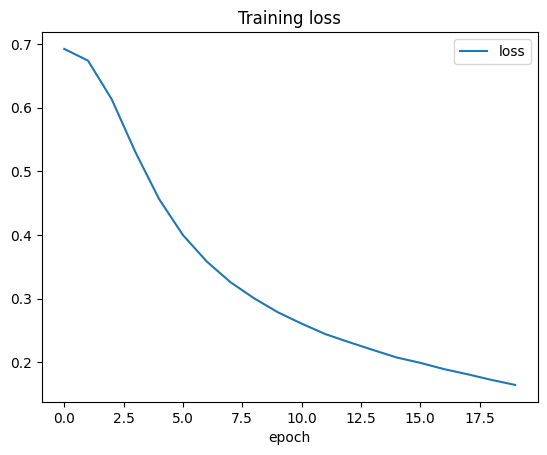

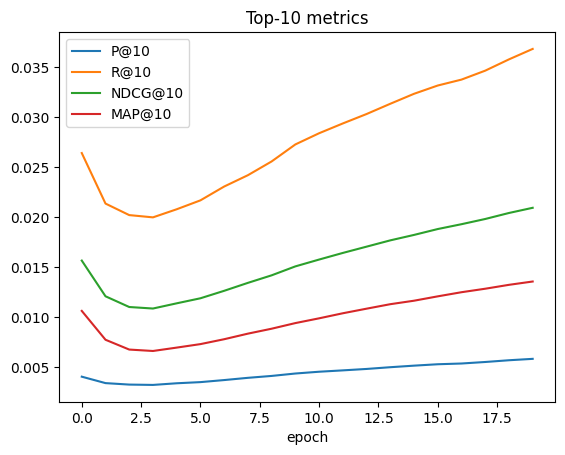

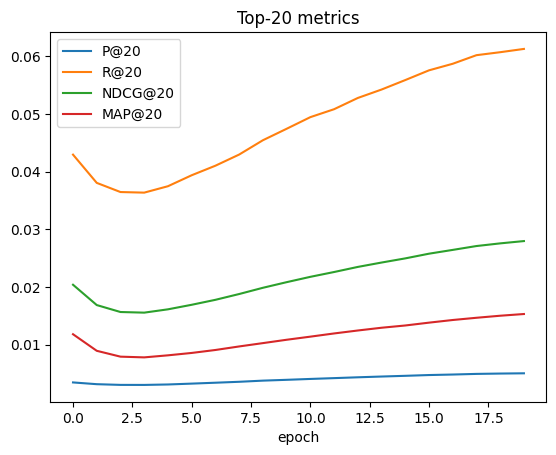

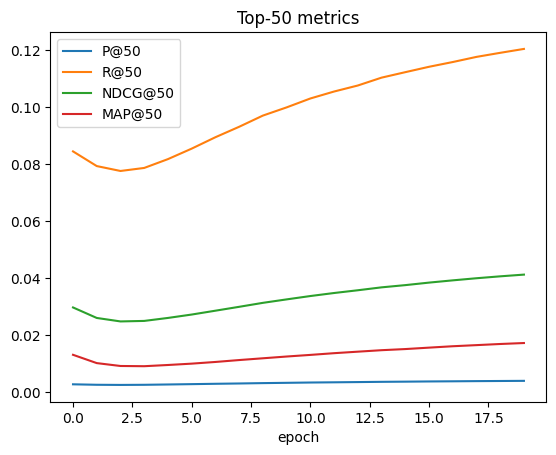

In [29]:
plt.figure()
plt.plot(history["loss"], label="loss")
plt.legend(); plt.xlabel("epoch"); plt.title("Training loss"); plt.show()

for K in K_LIST:
    plt.figure()
    plt.plot(hist_k[K]["prec"], label=f"P@{K}")
    plt.plot(hist_k[K]["rec"],  label=f"R@{K}")
    plt.plot(hist_k[K]["ndcg"], label=f"NDCG@{K}")
    plt.plot(hist_k[K]["map"],  label=f"MAP@{K}")
    plt.legend(); plt.xlabel("epoch"); plt.title(f"Top-{K} metrics")
    plt.show()

## Evaluation Metrics 

| **K** | **Precision@K** | **Recall@K** | **NDCG@K** | **MAP@K** |
|:------|:----------------|:-------------|:------------|:-----------|
| **10** | 0.0058 (0.58%) | 0.0368 (3.68%) | 0.0209 | 0.0136 |
| **20** | 0.0050 (0.50%) | 0.0613 (6.13%) | 0.0280 | 0.0153 |
| **50** | 0.0040 (0.40%) | 0.1203 (12.03%) | 0.0412 | 0.0173 |

Evaluation metrics of the LightGCN Collaborative Filtering Model (trained for 20 epochs, LR = 1e-3, embedding_dim = 64, 3 layers)

---

### Interpretation & Evaluation

The LightGCN model demonstrates **consistent convergence** and a clear upward trend across all ranking metrics:

- **Recall@K:** The most important metric here — it steadily improves to **0.1203 @K=50**, indicating that users are increasingly seeing relevant restaurants within their top-N recommendations.  
- **Precision@K:** Remains low (≈0.4–0.6%), which is typical for large item catalogs where only a small fraction of recommended items can be relevant. Precision may be improved later via reranking or hybrid enrichment with content signals.  
- **NDCG & MAP:** Both rise monotonically, confirming that LightGCN not only finds more relevant items but also ranks them higher within the recommendation list.  

Overall, these results indicate that the **LightGCN architecture effectively captures collaborative signals** between users and restaurants even under sparse review data.  
Performance is strong in terms of *recall* and *ranking quality*, showing the model is learning meaningful latent user–item representations.  

However, the relatively low precision suggests that **pure collaborative filtering may struggle to model nuanced user preferences** (e.g., cuisine type, ambience, price level). Future iterations can integrate **content-based features** or fine-tuned re-ranking layers to boost recommendation specificity.